<a href="https://colab.research.google.com/github/nadia-maarfavi/Projects/blob/master/FeatureAnalysisWithBudget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install shap

In [141]:
import pandas as pd
import numpy as np
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
import shap
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

In [8]:
def con(onecol):
  return (onecol.split(','))

In [9]:
def concomp(onecol):
  onecol = str(onecol)
  return (onecol.split(','))

In [10]:
def count(onecol):
  cnt = 0
  for i in range(len(onecol)):
    if(onecol[i]!=""):
      cnt+=1
  return cnt

In [11]:
def unpackCol(list, df):
    for i in range(len(df)):
        for name in list[i]:
            if name not in df.columns:
                df[name] = 0
            df[name][i] = 1
    return df

In [12]:
#Load in the data
train = pd.read_csv("/content/drive/MyDrive/DataAnalysis/DatasetWithBudgets.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Movie                844 non-null    object 
 1   PublishDate          844 non-null    object 
 2   Budget               844 non-null    int64  
 3   Language             844 non-null    object 
 4   Year                 844 non-null    int64  
 5   Timeminute           844 non-null    int64  
 6   Genres               844 non-null    object 
 7   FirstGenre           844 non-null    object 
 8   MPAA                 844 non-null    object 
 9   MovieDirectors       844 non-null    object 
 10  DirectorID           844 non-null    int64  
 11  Movie_Stars          844 non-null    object 
 12  StarsID1             844 non-null    int64  
 13  StarsID2             844 non-null    int64  
 14  StarsID3             844 non-null    int64  
 15  StarsID4             844 non-null    int

In [13]:
train_features = []
log_features = []
cols_to_drop = []


# ***Total Comments***

In [14]:
print('Movies missing total comments:',train.total.isna().sum())

Movies missing total comments: 0


In [15]:
print("Mean total comments: %.2f" % train.total.mean())
print("Median total comments: %.2f" % train.total.median())
print("Mean log total comments: %.2f" % (np.log1p(train.total)).mean())
print("Median log total comments: %.2f" % (np.log1p(train.total)).median())

Mean total comments: 889.51
Median total comments: 362.50
Mean log total comments: 5.77
Median log total comments: 5.90


In [16]:
train['log_total'] = np.log1p(train['total'])
train['log_mean'] = np.log1p(train['mean'])
train['log_median'] = np.log1p(train['median'])
train['log_std'] = np.log1p(train['std'])


# ***Movie Name***

In [17]:
print('Movies missing a title:',train.Movie.isna().sum())
train['title_len'] = train.Movie.apply(lambda x: len(str(x)))

Movies missing a title: 0


We will just be looking at the length of the title, to see if this has any effect on a film's draw. Possibly shorter titles are easier to remember, making them perfrom better, or there is a chance that longer titles are more unique and compelling, making them pull more people in. Let's take a look at the data and see.



`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


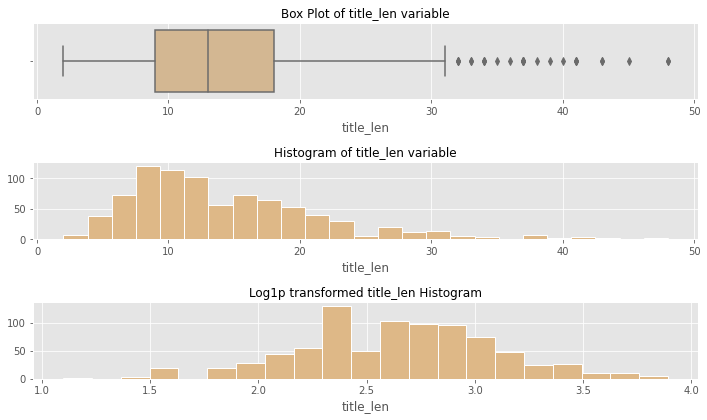

In [18]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.title_len, ax = ax[0], color='burlywood')
ax[0].set_title("Box Plot of title_len variable")
sns.distplot(a=train.title_len, kde = False, ax = ax[1], color='burlywood', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of title_len variable")
sns.distplot(a=np.log1p(train.title_len), kde = False, ax = ax[2], color='burlywood', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed title_len Histogram")
f.tight_layout()

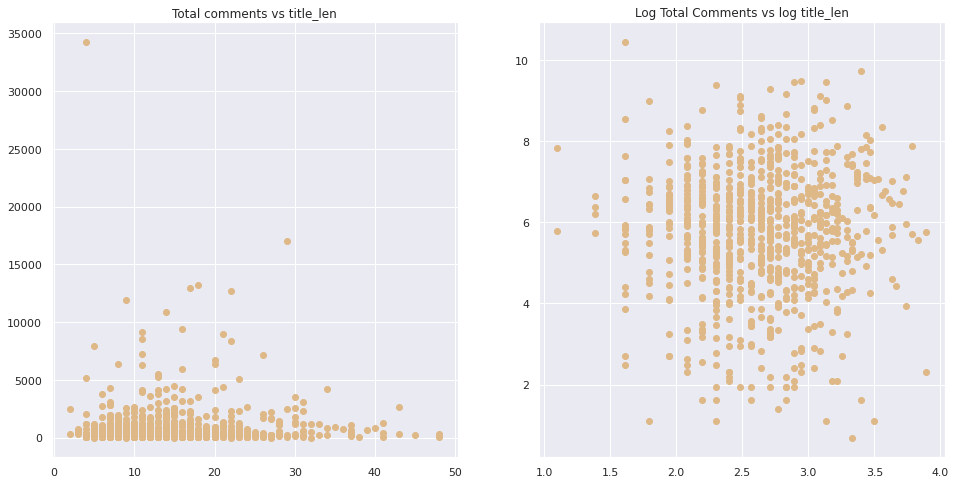

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['title_len'], train['total'], color='burlywood')
plt.title('Total comments vs title_len');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['title_len']), np.log1p(train['total']), color='burlywood')
plt.title('Log Total Comments vs log title_len');

In [20]:

# calculate Pearson's correlation
corr, _ = pearsonr(train['title_len'], train['total'])
print('Pearsons correlation between title_len and total comments: %.3f' % corr)
corr, _ = pearsonr((train['title_len']), np.log1p(train['total']))
print('Pearsons correlation between log transformed title_len and log transformed total comments: %.3f' % corr)

Pearsons correlation between title_len and total comments: 0.026
Pearsons correlation between log transformed title_len and log transformed total comments: 0.028


We can see that there is very little correlation between the length of the title and the total comments for the film.



In [21]:
train_features.append('title_len')

# ***Language***

In [22]:
print("Counts of each original language:")
print(train['Language'].value_counts()[:10])
#Creating new feature
train['originally_english'] = train.Language.apply(lambda x: 1 if x == 'English' else 0)
print(train['originally_english'].value_counts())
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['originally_english'], train['total'])
print('Pearsons correlation between in_english and total comments: %.3f' % corr)

Counts of each original language:
English                   824
Mandarin                    4
Spanish                     3
Chinese                     2
French                      2
Norwegian                   2
American Sign Language      1
Hindi                       1
Italian                     1
Khmer                       1
Name: Language, dtype: int64
1    824
0     20
Name: originally_english, dtype: int64
Pearsons correlation between in_english and total comments: 0.045


In [23]:
train_features.append('originally_english')

# ***Stars and Direcor***

In [24]:
train_features.append('StarsID1')
train_features.append('StarsID2')
train_features.append('StarsID3')
train_features.append('StarsID4')
train_features.append('DirectorID')

# ***Sequel***

In [25]:
print(train.Follows.value_counts())
train['Follows'] = train.Follows.apply(lambda x: 1 if x >= 1 else 0)
print(train['Follows'].value_counts())

0     712
1      69
2      19
3      12
4      10
5       6
8       5
7       4
6       2
23      1
18      1
15      1
11      1
9       1
Name: Follows, dtype: int64
0    712
1    132
Name: Follows, dtype: int64


In [26]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['Follows'], train['total'])
print('Pearsons correlation between Sequel and total Comments: %.3f' % corr)
corr, _ = pearsonr(train['Follows'], np.log1p(train['total']))
print('Pearsons correlation between Sequel and the log total Comments: %.3f' % corr)

Pearsons correlation between Sequel and total Comments: 0.192
Pearsons correlation between Sequel and the log total Comments: 0.268


In [27]:
train_features.append('Follows')

# ***Budget***

In [28]:
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['Budget'], train['total'])
print('Pearsons correlation between budget and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['Budget']), np.log1p(train['total']))
print('Pearsons correlation between log budgetd and log revenue: %.3f' % corr)

Pearsons correlation between budget and revenue: 0.454
Pearsons correlation between log budgetd and log revenue: 0.564


In [29]:
log_features.append('Budget')


# ***Genres***

In [30]:
def extract_data(column_name):
    #df['cast']=df['cast'].astype(str)
    #df['director']=df['director'].astype(str)
    
    # From the column entered, eparate the string by '|'
    all_data = train[column_name].str.cat(sep = ',')
    
    # StorE the values separately as series
    all_data = pd.Series(all_data.split(','))
    
    # Read the descending order, starts with highest number
    count = all_data.value_counts(ascending = False)
    
    return count

In [31]:
genres_count = extract_data('Genres')
genres_count = pd.DataFrame(data=genres_count)

top_genres = genres_count.head(10)
top_genres

,0
Drama,456
Comedy,280
Action,280
Crime,177
Thriller,174
Adventure,144
Horror,111
Romance,110
Biography,97
Mystery,90


In [32]:
train['genres_reform']= train['Genres'].apply(con)
train['genres_reform']

0                  [Comedy, Horror]
1                   [Drama, Sci-Fi]
2           [Comedy, Drama, Family]
3                     [Documentary]
4       [Horror, Mystery, Thriller]
                   ...             
839            [Adventure, Fantasy]
840     [Action, Adventure, Sci-Fi]
841    [Action, Adventure, Fantasy]
842     [Action, Adventure, Sci-Fi]
843      [Action, Adventure, Drama]
Name: genres_reform, Length: 844, dtype: object

In [33]:
# example of using it to unpack the genres 
train = unpackCol(train['genres_reform'], train)

# here's what it did
print(train.columns)
print()


Index(['Movie', 'PublishDate', 'Budget', 'Language', 'Year', 'Timeminute',
       'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors', 'DirectorID',
       'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3', 'StarsID4',
       'Countries', 'Follows', 'ProductionCompanies', 'ReleaseDate', 'mean',
       'median', 'std', 'total', 'Label', 'log_total', 'log_mean',
       'log_median', 'log_std', 'title_len', 'originally_english',
       'genres_reform', 'Comedy', 'Horror', 'Drama', 'Sci-Fi', 'Family',
       'Documentary', 'Mystery', 'Thriller', 'Fantasy', 'Romance', 'Action',
       'Musical', 'War', 'Biography', 'History', 'Crime', 'Adventure',
       'Western', 'Animation', 'Sport'],
      dtype='object')



In [35]:
corr, _ = pearsonr(train['Action'], train['total'])
print('Pearsons correlation between Comedy and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['Action']), np.log1p(train['total']))
print('Pearsons correlation between Comedy and total comments: %.3f' % corr)

Pearsons correlation between Comedy and total comments: 0.188
Pearsons correlation between Comedy and total comments: 0.245


In [36]:
train_features.append('Comedy')
train_features.append('Horror')
train_features.append('Drama')
train_features.append('Sci-Fi')
train_features.append('Family')
train_features.append('Documentary')
train_features.append('Thriller')
train_features.append('Mystery')
train_features.append('Fantasy')
train_features.append('Romance')
train_features.append('Action')
train_features.append('Musical')
train_features.append('War')
train_features.append('Biography')
train_features.append('History')
train_features.append('Crime')
train_features.append('Adventure')
train_features.append('Western')
train_features.append('Animation')
train_features.append('Sport')

# ***Production Countries***

In [37]:
print('Movies missing production countries:',train.Countries.isna().sum())

Movies missing production countries: 0


In [38]:
train['production_countries_processed'] = train['Countries'].apply(con)

In [39]:
#Creating new feature
train['Countries'] = train.Countries.apply(lambda x: 1 if 'USA' in x else 0)
train['Countries'].value_counts()

1    797
0     47
Name: Countries, dtype: int64

In [40]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['Countries'], train['total'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.079


In [41]:
train_features.append('Countries')

# ***Production Companies***

In [42]:

def checkStudios(studios):
    #print(studios)
    if len(studios) < 1:
        #print("Return 0")
        return 0
    count = 0
    for company in range(len(studios)):
        #print("Company: ", studios[company])
        if studios[company] in list(TopStudios):
            count += 1
    #print("Count: ",count)
    return count

In [43]:
train['ProductionCompanies'].head(10)
train['ProductionCompanies'].isna().sum()

2

In [44]:
train['ProductionCompanies'] = train['ProductionCompanies'].fillna("")
train['production_companies_reform']= train['ProductionCompanies'].apply(con)
train['production_companies_reform'].head(10)

0                              [TudorFilms Production]
1                                               [erbp]
2                           [Lucky Coffee Productions]
3                              [Peel Here Productions]
4    [New Line Cinema, Blumhouse Productions, Enter...
5    [Sailor Bear, Zero Trans Fat Productions, Idea...
6                                                   []
7           [RADiUS-TWC, Duplass Brothers Productions]
8                               [Filmic Entertainment]
9    [Aristar Entertainment, Belligerent Seal Produ...
Name: production_companies_reform, dtype: object

In [45]:
train['num_studios'] = train.production_companies_reform.apply(count)
train['num_studios'].value_counts()

3     154
4     140
2     115
5     111
6      77
7      62
8      55
1      46
9      23
10     19
11     11
12      7
15      5
13      5
14      3
27      2
17      2
18      2
19      2
0       2
21      1
Name: num_studios, dtype: int64

In [46]:
TopStudios = ["Walt Disney Pictures", "Warner Bros.", "Sony Pictures", "Universal Pictures", "Twentieth Century Fox", "Paramount Pictures", "Lionsgate", "New Line Cinema", "Dreamworks Pictures", "Miramax", "Metro-Goldwyn-Mayer (MGM)", "Fox Searchlight", "Focus Features, Weinstein Co.", "Summit Entertainment", "Sony Pictures Classics", "STX Entertainment", "Miramax/Dimension", "Relativity", "Open Road Films (II)", "Marvel Studios"]

#numTopStudios refer to number of top studios for each movie, how many top stuidos each movie has
train['numTopStudios'] = train['production_companies_reform'].apply(lambda x: checkStudios(x))
train['numTopStudios'].value_counts()

0    539
1    263
2     40
3      2
Name: numTopStudios, dtype: int64

In [48]:
# if at least one of the movie production companies are in the top list
train['topStudio'] = train.numTopStudios.apply(lambda x: 1 if x >= 1 else 0)
print(train['topStudio'].value_counts())

0    539
1    305
Name: topStudio, dtype: int64


In [49]:
# analysis of correlation and create log feature
corr, _ = pearsonr(train['topStudio'], train['total'])
print('Pearsons correlation between topStudio and total comments: %.3f' % corr)
corr, _ = pearsonr((train['topStudio']), np.log1p(train['total']))
print('Pearsons correlation between log topStudio and total comments: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['numTopStudios'], train['total'])
print('Pearsons correlation between numTopStudios and comments: %.3f' % corr)
corr, _ = pearsonr((train['numTopStudios']), np.log1p(train['total']))
print('Pearsons correlation between log numTopStudios and total comments: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['num_studios'], train['total'])
print('Pearsons correlation between num_studios and total comments: %.3f' % corr)
corr, _ = pearsonr((train['num_studios']), np.log1p(train['total']))
print('Pearsons correlation between log num_studios and total comments: %.3f' % corr)

Pearsons correlation between topStudio and total comments: 0.202
Pearsons correlation between log topStudio and total comments: 0.393

Pearsons correlation between numTopStudios and comments: 0.217
Pearsons correlation between log numTopStudios and total comments: 0.388

Pearsons correlation between num_studios and total comments: 0.101
Pearsons correlation between log num_studios and total comments: 0.166


In [51]:
train_features.append('topStudio')
train_features.append('numTopStudios')

# ***MPAA***

In [52]:
train['MPAA'].value_counts()

R            412
PG-13        318
Not Rated     52
PG            46
TV-MA          8
TV-14          8
Name: MPAA, dtype: int64

In [53]:
def nominal(mpaa):
  if (mpaa=="Not Rated"):
    return 0
  if (mpaa=='G'):
    return 1
  if (mpaa=='PG'):
    return 2
  if (mpaa=='PG-13' or mpaa=='TV-14' or mpaa=='13+' or mpaa=='14A'):
    return 3
  if (mpaa=='R'):
    return 4
  if (mpaa=='TV-MA'or mpaa=='18A'):
    return 5


In [54]:
train['RatingMPAA'] = train['MPAA'].apply(nominal)
train['RatingMPAA'].value_counts()

4    412
3    326
0     52
2     46
5      8
Name: RatingMPAA, dtype: int64

In [55]:
# analysis of correlation and create log feature
corr, _ = pearsonr(train['RatingMPAA'], train['total'])
print('Pearsons correlation between RatingMPAA and total comments: %.3f' % corr)
corr, _ = pearsonr((train['RatingMPAA']), np.log1p(train['total']))
print('Pearsons correlation between log RatingMPAA and total comments: %.3f' % corr)
print()

Pearsons correlation between RatingMPAA and total comments: -0.001
Pearsons correlation between log RatingMPAA and total comments: 0.255



In [56]:
train_features.append('RatingMPAA')

# ***Trailer Publish Date***

In [57]:
train.columns

Index(['Movie', 'PublishDate', 'Budget', 'Language', 'Year', 'Timeminute',
       'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors', 'DirectorID',
       'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3', 'StarsID4',
       'Countries', 'Follows', 'ProductionCompanies', 'ReleaseDate', 'mean',
       'median', 'std', 'total', 'Label', 'log_total', 'log_mean',
       'log_median', 'log_std', 'title_len', 'originally_english',
       'genres_reform', 'Comedy', 'Horror', 'Drama', 'Sci-Fi', 'Family',
       'Documentary', 'Mystery', 'Thriller', 'Fantasy', 'Romance', 'Action',
       'Musical', 'War', 'Biography', 'History', 'Crime', 'Adventure',
       'Western', 'Animation', 'Sport', 'production_countries_processed',
       'production_companies_reform', 'num_studios', 'numTopStudios',
       'topStudio', 'RatingMPAA'],
      dtype='object')

In [58]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days

In [59]:
MovieDate = train.ReleaseDate.values
TrailerDate = train.PublishDate.values
difference = []


for i in range(len(MovieDate)):
   d1 = MovieDate[i]
   d2 = TrailerDate[i]
   difference.append(days_between(d2,d1))

train["Difference"] = difference

In [60]:
# analysis of correlation and create log feature
corr, _ = pearsonr(train['Difference'], train['total'])
print('Pearsons correlation between Difference and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['Difference']), np.log1p(train['total']))
print('Pearsons correlation between log Difference and total comments: %.3f' % corr)
print()

Pearsons correlation between Difference and total comments: 0.285
Pearsons correlation between log Difference and total comments: 0.501



In [61]:
log_features.append('Difference')

# ***Cols to Drop***

In [62]:
train.columns

Index(['Movie', 'PublishDate', 'Budget', 'Language', 'Year', 'Timeminute',
       'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors', 'DirectorID',
       'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3', 'StarsID4',
       'Countries', 'Follows', 'ProductionCompanies', 'ReleaseDate', 'mean',
       'median', 'std', 'total', 'Label', 'log_total', 'log_mean',
       'log_median', 'log_std', 'title_len', 'originally_english',
       'genres_reform', 'Comedy', 'Horror', 'Drama', 'Sci-Fi', 'Family',
       'Documentary', 'Mystery', 'Thriller', 'Fantasy', 'Romance', 'Action',
       'Musical', 'War', 'Biography', 'History', 'Crime', 'Adventure',
       'Western', 'Animation', 'Sport', 'production_countries_processed',
       'production_companies_reform', 'num_studios', 'numTopStudios',
       'topStudio', 'RatingMPAA', 'Difference'],
      dtype='object')

In [63]:
train_features

['title_len',
 'originally_english',
 'StarsID1',
 'StarsID2',
 'StarsID3',
 'StarsID4',
 'DirectorID',
 'Follows',
 'Comedy',
 'Horror',
 'Drama',
 'Sci-Fi',
 'Family',
 'Documentary',
 'Thriller',
 'Mystery',
 'Fantasy',
 'Romance',
 'Action',
 'Musical',
 'War',
 'Biography',
 'History',
 'Crime',
 'Adventure',
 'Western',
 'Animation',
 'Sport',
 'Countries',
 'topStudio',
 'numTopStudios',
 'RatingMPAA']

In [64]:
log_features

['Budget', 'Difference']

In [65]:
cols_to_drop.append("Movie")
cols_to_drop.append("Language")
cols_to_drop.append("Year")
cols_to_drop.append("Genres")
cols_to_drop.append("FirstGenre")
cols_to_drop.append("Timeminute")
cols_to_drop.append("MPAA")
cols_to_drop.append("ProductionCompanies")
cols_to_drop.append("ReleaseDate")
cols_to_drop.append("mean")
cols_to_drop.append("median")
cols_to_drop.append("std")
cols_to_drop.append("Label")
cols_to_drop.append("genres_reform")
cols_to_drop.append("production_countries_processed")
cols_to_drop.append("production_companies_reform")
cols_to_drop.append("num_studios")

# ***Feature Selection***

In [66]:
print(cols_to_drop)

['Movie', 'Language', 'Year', 'Genres', 'FirstGenre', 'Timeminute', 'MPAA', 'ProductionCompanies', 'ReleaseDate', 'mean', 'median', 'std', 'Label', 'genres_reform', 'production_countries_processed', 'production_companies_reform', 'num_studios']


In [67]:
print(train_features)

['title_len', 'originally_english', 'StarsID1', 'StarsID2', 'StarsID3', 'StarsID4', 'DirectorID', 'Follows', 'Comedy', 'Horror', 'Drama', 'Sci-Fi', 'Family', 'Documentary', 'Thriller', 'Mystery', 'Fantasy', 'Romance', 'Action', 'Musical', 'War', 'Biography', 'History', 'Crime', 'Adventure', 'Western', 'Animation', 'Sport', 'Countries', 'topStudio', 'numTopStudios', 'RatingMPAA']


In [68]:
print(log_features)

['Budget', 'Difference']


We will log transform all of these features and add them to our set of features for our model.



In [69]:
for feat in log_features:
    train["log_" + feat] = np.log1p(train[feat])
    if feat is not "total":
        train_features.append("log_" + feat)


In [70]:
print(train_features)
print()
print("Number of features: ", len(train_features))

['title_len', 'originally_english', 'StarsID1', 'StarsID2', 'StarsID3', 'StarsID4', 'DirectorID', 'Follows', 'Comedy', 'Horror', 'Drama', 'Sci-Fi', 'Family', 'Documentary', 'Thriller', 'Mystery', 'Fantasy', 'Romance', 'Action', 'Musical', 'War', 'Biography', 'History', 'Crime', 'Adventure', 'Western', 'Animation', 'Sport', 'Countries', 'topStudio', 'numTopStudios', 'RatingMPAA', 'log_Budget', 'log_Difference']

Number of features:  34


In [ ]:
#train_features_list = ['title_len', 'originally_english', 'StarsID1', 'StarsID2', 'StarsID3', 'StarsID4', 'DirectorID', 'Follows', 'Comedy', 'Horror', 'Drama', 'Sci-Fi', 'Family', 'Documentary', 'Thriller', 'Mystery', 'Fantasy', 'Romance', 'Action', 'Musical', 'War', 'Biography', 'History', 'Crime', 'Adventure', 'Western', 'Animation', 'Sport', 'Countries', 'topStudio', 'numTopStudios', 'RatingMPAA', 'log_Budget', 'log_Difference']


We ended with a total of 34 different features for our model. Next let's have a look at the correlation matrix of all our our numerical features.



Text(0.5, 1.0, 'Correlation between numerical features')

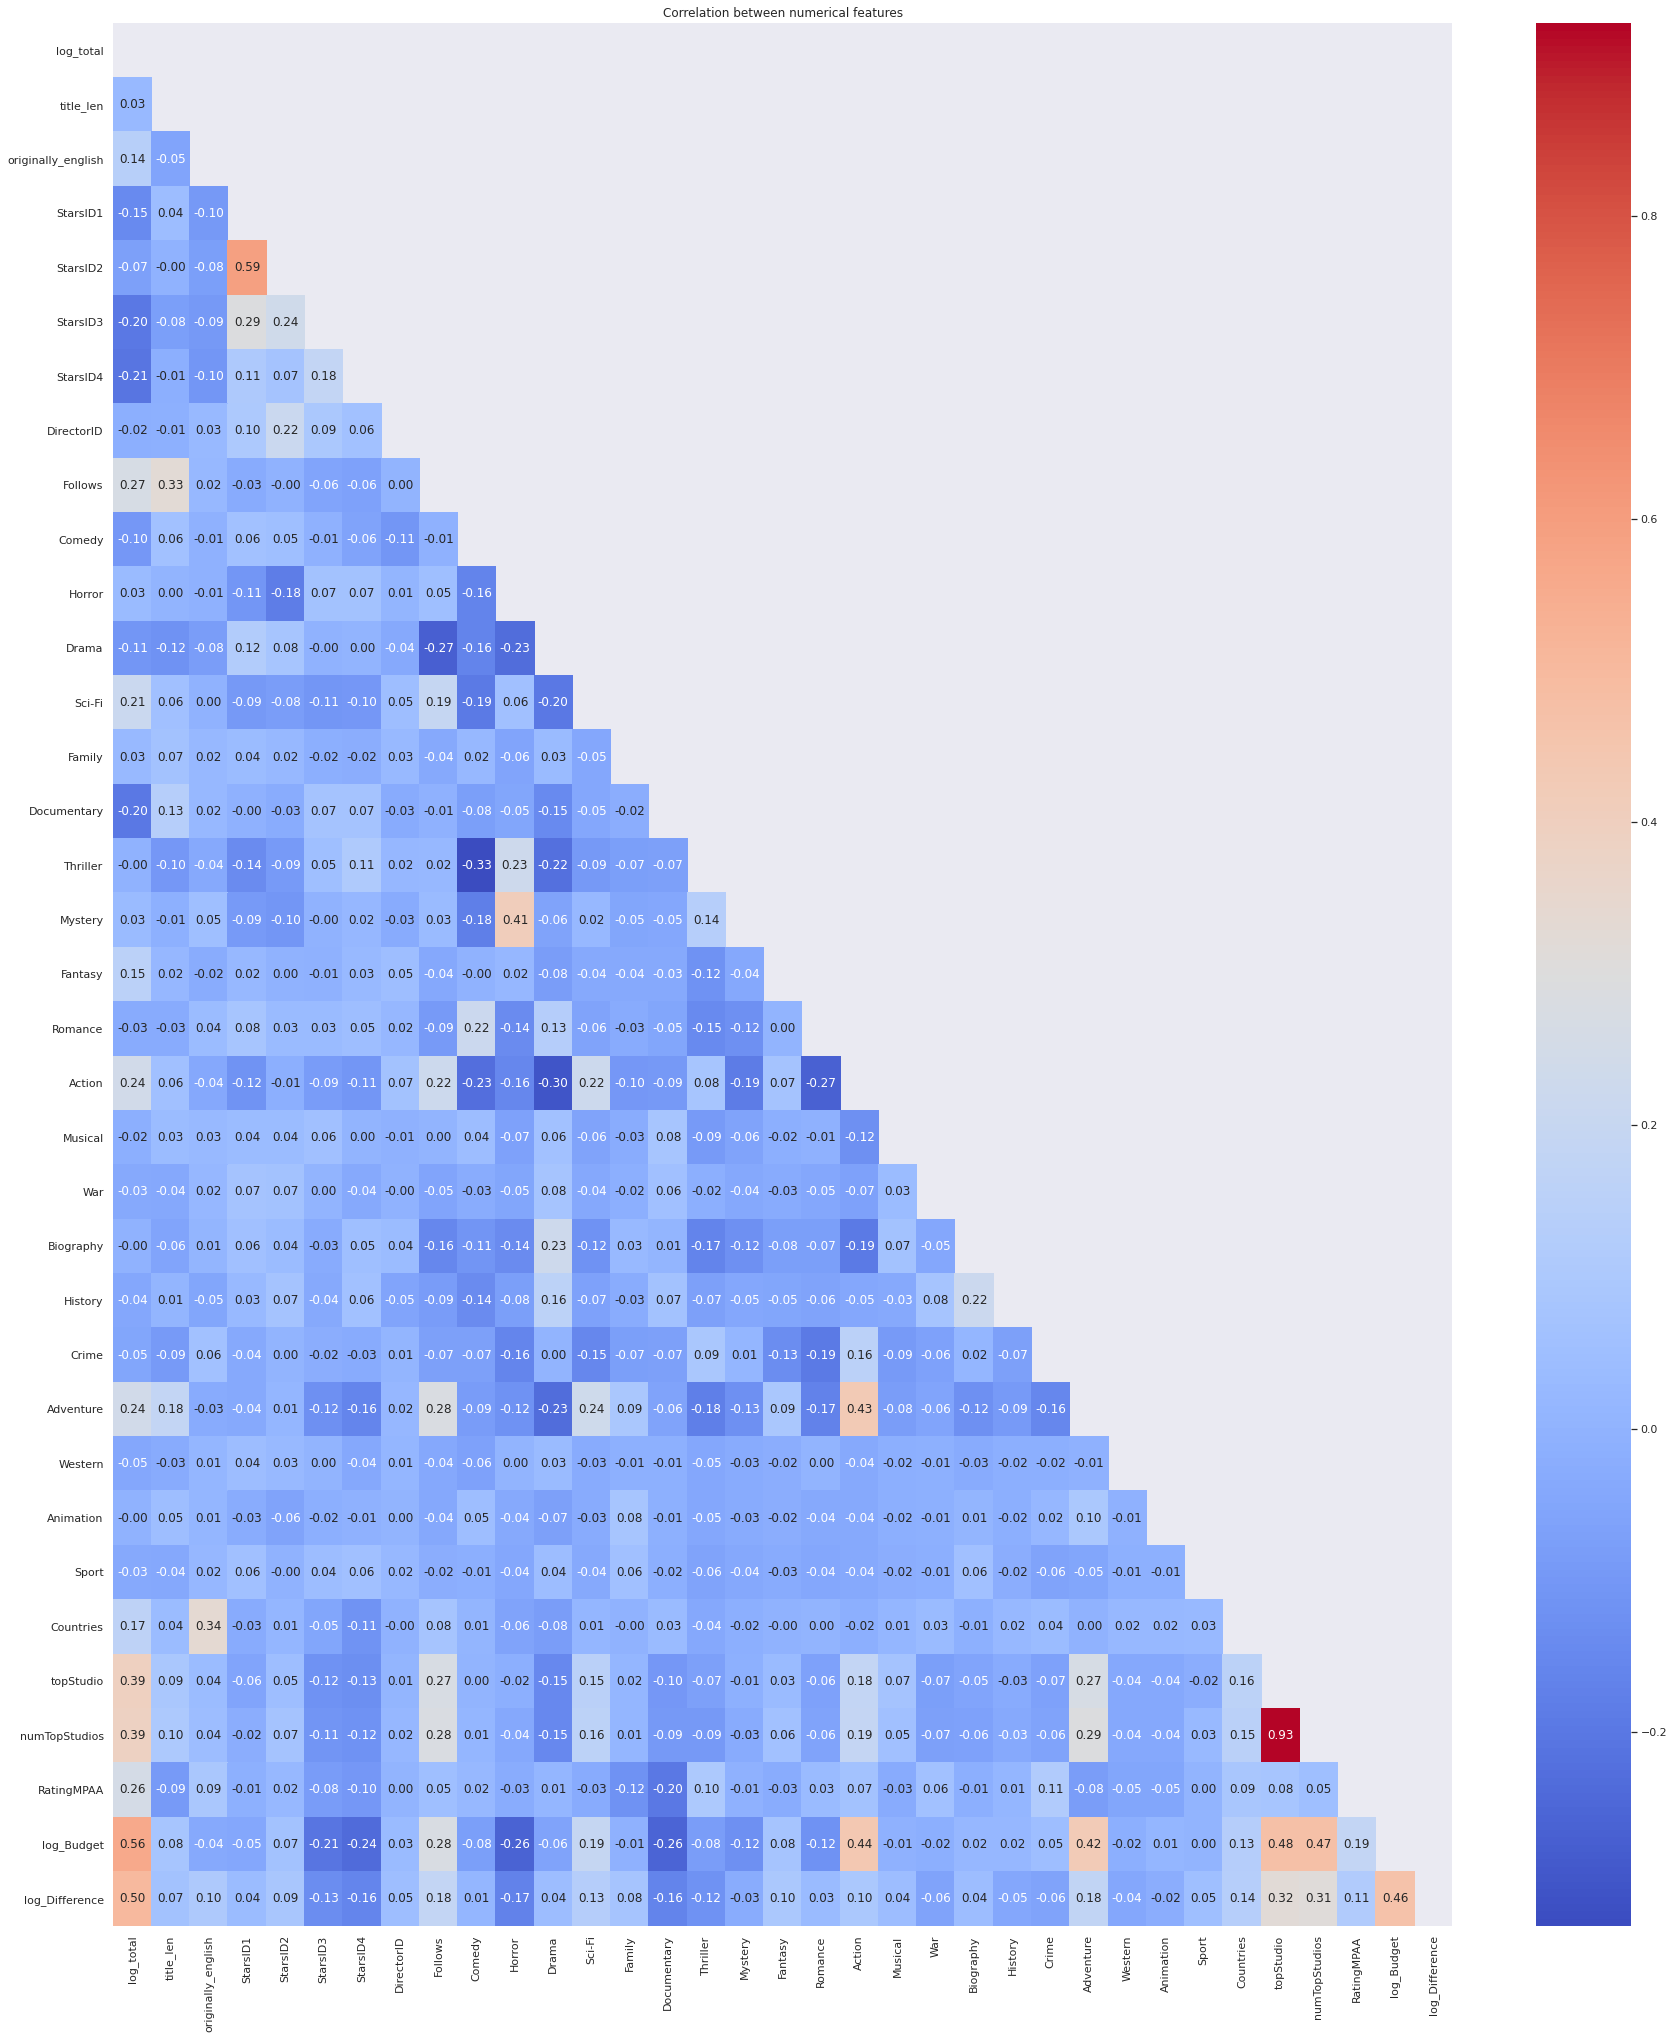

In [72]:
# Correlation matrix
sns.set(rc={'figure.figsize':(30,35)})

# Compute the correlation matrix
corr = train[['log_total', *train_features]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')

plt.title("Correlation between numerical features")

# ***Modeling***

In [73]:
#Set up our X and y
X = train[train_features]
y = train['log_total']

In [74]:
# create a 80/20 stratified split of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

In [75]:
#Ensure the dimensions are correct
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (675, 34) (675,)
Test set: (169, 34) (169,)


Next we will define a few helper functions for efficiency and organization. The first one is to be used to perform a grid search fo hyperparameter tuning for each of our models. The next one is an evaluation to compare our baseline model to the tuned model and show us the percent difference, and the last one simply outputs several metrics to judge the performance of our models on.

In [76]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_root_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [77]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%'.format(accuracy))
    
    return accuracy

In [136]:
def metrics(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    #errors = abs(y_pred - y_test)
    #mae = np.mean(errors)
    #mape = 100 * (errors / y_test)
    MedAE = np.median(errors)
    r2 = r2_score(y_test, y_pred)
    print('Mean Squared Error: ', round(mse, 4))
    print('Root Mean Squared Error: ', round(rmse, 4))
    print('Mean Absolute Error: ', round(mae, 4))
    print('Median Absolute Error: ', round(MedAE, 4))
    print('R2 Score: ', round(r2, 4))
    
    # Calculate and display accuracy
    test_accuracy = 100 - np.mean(mape)
    print('Test Set Accuracy (from Mean Absolute Percentage Error):{:.3f}%'.format(test_accuracy))

# ***Random Forest***

In [130]:
rfr_base_model = RandomForestRegressor(random_state=42)
rfr_base_model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [131]:
y_pred = rfr_base_model.predict(X_test)


In [132]:
errors = abs(np.expm1(y_pred) - np.expm1(y_test.values))
# Print out the mean absolute error (mae)
print('Average Error:', round(np.mean(errors), 2))

Average Error: 665.1


In [133]:
print('Random Forest Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Random Forest Baseline Model Metrics:
Mean Squared Error:  1.1998
Root Mean Squared Error:  1.0954
Mean Absolute Error:  0.8466
Median Absolute Error:  245.0432
R2 Score:  0.4543
Test Set Accuracy (from Mean Absolute Percentage Error):83.303%


***Grid Search Hyperparameter Tuning***

In [134]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 25, 30],
    'max_features': [.4, 'auto'],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [1, 3, 5],
    'n_estimators': [100,400]
}

# Create a based model
rfr = RandomForestRegressor(random_state=42)
# Instantiate the grid search model
rfr, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, rfr, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-rfr.best_score_))
print(rfr.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  4.0min finished


1.0313393096660781
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


In [86]:
print('Base Model:')
base_accuracy = evaluate(rfr_base_model, X_test, y_test.values)
print()
print('Model after Tuning:')
rfr_best_model = rfr.best_estimator_
best_accuracy = evaluate(rfr_best_model, X_test, y_test.values)

print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Base Model:
Average Error: 0.8466
Accuracy = 83.303%

Model after Tuning:
Average Error: 0.8271
Accuracy = 83.689%
Improvement of 0.46%.


In [87]:
y_pred = rfr_best_model.predict(X_test)
print('Random Forest Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Random Forest Model (After Tuning) Metrics:
Mean Squared Error:  1.1199
Root Mean Squared Error:  1.0583
Mean Absolute Error:  0.8271
Median Absolute Error:  0.6753
R2 Score:  0.4907
Test Set Accuracy (from Mean Absolute Percentage Error):83.689%


In [96]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from numpy import absolute
from numpy import mean

scoring = {'r2': 'r2',
           'MAE': 'neg_mean_absolute_error',
           'RMSE': 'neg_root_mean_squared_error'}



kfold = KFold(n_splits=10)
cv_results = cross_validate(rfr_best_model, X, y, cv=kfold, scoring= scoring, n_jobs=-1)
MeanR2 = round(cv_results['test_r2'].mean(),4)
MeanMAE = round((absolute(cv_results['test_MAE'])).mean(),4)
MeanRMSE = round((absolute(cv_results['test_RMSE'])).mean(),4)

In [98]:
print(MeanR2)
print(MeanMAE)
print(MeanRMSE)

0.1851
0.865
1.0998


***Feature Importances***


In [99]:

feature_importances = rfr_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_Budget (0.232665)
2. log_Difference (0.173751)
3. StarsID1 (0.109203)
4. StarsID3 (0.095504)
5. StarsID2 (0.058807)
6. RatingMPAA (0.054130)
7. DirectorID (0.053109)
8. StarsID4 (0.038567)
9. title_len (0.029330)
10. numTopStudios (0.026700)
11. topStudio (0.023667)
12. Follows (0.013096)
13. Horror (0.010951)
14. Action (0.010637)
15. Adventure (0.008828)
16. originally_english (0.007883)
17. Comedy (0.007713)
18. Drama (0.005676)
19. Mystery (0.005644)
20. Crime (0.004945)


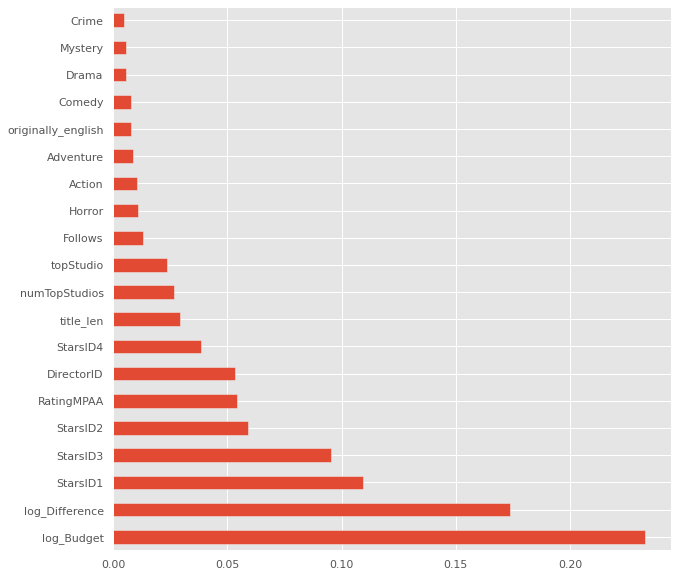

In [100]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

To further interpret our models, we will also look at the SHAP values. SHAP is an acronym for SHapley Additive exPlanations and was developed by Scott M. Lundberg. These values are incredibly useful and a great visualization to help understand some of the more complex models, such as a Random Forest. Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature. However, since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared. This helps us see why the algorithm made the decision in did in many cases.

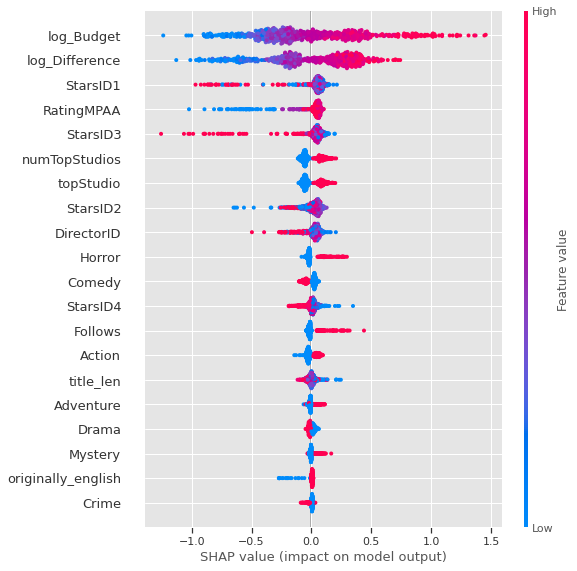

In [101]:
explainer = shap.TreeExplainer(rfr_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

# ***Extra Trees***

***baseline***

In [102]:
et_base_model = ExtraTreesRegressor(random_state = 42)
et_base_model.fit(X_train, y_train.values.ravel())

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [103]:
y_pred = et_base_model.predict(X_test)

In [104]:
print('Extra Trees Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Extra Trees Baseline Model Metrics:
Mean Squared Error:  1.1314
Root Mean Squared Error:  1.0637
Mean Absolute Error:  0.8519
Median Absolute Error:  0.7222
R2 Score:  0.4855
Test Set Accuracy (from Mean Absolute Percentage Error):83.798%


***Grid Search Hyperparameter Tuning***

In [105]:
et_model = ExtraTreesRegressor(random_state = 42)
param_grid = {
    'bootstrap': [True],
    'max_depth': [35, 40, 45],
    'max_features': [.4, .6, 'auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [4, 5, 7],
    'n_estimators': [100, 250, 400]
}

et_model, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, et_model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-et_model.best_score_))
print(et_model.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  5.4min finished


1.029489489308181
{'bootstrap': True, 'max_depth': 35, 'max_features': 0.6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}


In [106]:
base_accuracy = evaluate(et_base_model, X_test, y_test.values)

et_best_model = et_model.best_estimator_
best_accuracy = evaluate(et_best_model, X_test, y_test.values)


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Average Error: 0.8519
Accuracy = 83.798%
Average Error: 0.8511
Accuracy = 83.589%
Improvement of -0.25%.


In [107]:
y_pred = et_best_model.predict(X_test)
print('Extra Trees Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Extra Trees Model (After Tuning) Metrics:
Mean Squared Error:  1.1455
Root Mean Squared Error:  1.0703
Mean Absolute Error:  0.8511
Median Absolute Error:  0.7217
R2 Score:  0.479
Test Set Accuracy (from Mean Absolute Percentage Error):83.589%


***Feature Importances***

In [ ]:
feature_importances = et_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_Budget (0.157115)
2. log_Difference (0.122839)
3. RatingMPAA (0.085797)
4. topStudio (0.084486)
5. StarsID1 (0.067155)
6. StarsID3 (0.048190)
7. StarsID2 (0.046177)
8. numTopStudios (0.034398)
9. Action (0.032799)
10. StarsID4 (0.030511)
11. Comedy (0.025306)
12. DirectorID (0.024972)
13. title_len (0.024736)
14. Adventure (0.024065)
15. Follows (0.023529)
16. Drama (0.023370)
17. Crime (0.017675)
18. Horror (0.016084)
19. Thriller (0.015623)
20. Mystery (0.014332)


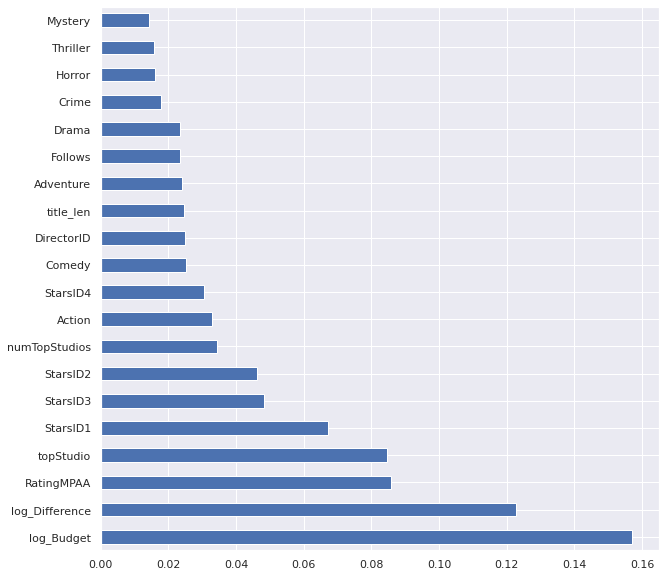

In [ ]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from numpy import absolute
from numpy import mean

scoring = {'r2': 'r2',
           'MAE': 'neg_mean_absolute_error',
           'RMSE': 'neg_root_mean_squared_error'}



kfold = KFold(n_splits=10)
cv_results = cross_validate(et_model, X, y, cv=kfold, scoring= scoring, n_jobs=-1)
MeanR2 = round(cv_results['test_r2'].mean(),4)
MeanMAE = round((absolute(cv_results['test_MAE'])).mean(),4)
MeanRMSE = round((absolute(cv_results['test_RMSE'])).mean(),4)

print(MeanR2)
print(MeanMAE)
print(MeanRMSE)

0.2058
0.8502
1.0835


# ***XGBoost***

The next model we will try is XGBoost. This is a library designed for efficiency and meant to be great for working with large amounts of data as it can supposedly run quickly and accurately. Our dataset is not too large by any means, but we will try it anyways. XGBoost implements algorithms under the gradient boosting framework and provides a parallel tree boosting to solve problems.

***Baseline***

In [108]:
xgb_base_model = xgb.XGBRegressor(random_state = 42)
xgb_base_model.fit(X_train, y_train.values.ravel())

[02:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [109]:
y_pred = xgb_base_model.predict(X_test)

In [110]:

print('XGBoost Baseline Model Metrics:')
metrics(y_pred, y_test.values)

XGBoost Baseline Model Metrics:
Mean Squared Error:  1.1338
Root Mean Squared Error:  1.0648
Mean Absolute Error:  0.8305
Median Absolute Error:  0.669
R2 Score:  0.4843
Test Set Accuracy (from Mean Absolute Percentage Error):83.646%


**Grid Search Hyperparameter Tuning**

In [111]:
xgb_model = xgb.XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'colsample_bytree': [0.9, 1.0, 1.1],
    'max_depth': [2, 5, 10],
    'reg_alpha': [1.0, 1.2, 1.3],
    'reg_lambda': [ 1.2, 1.3, 1.4],
    'subsample': [0.9, 1.0]
}

xgb_model, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, xgb_model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-xgb_model.best_score_))
print(xgb_model.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 591 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.1min


[02:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.0335949057147333
{'colsample_bytree': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.4, 'subsample': 0.9}


[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  3.0min finished


In [112]:
print('Base Model:')
base_accuracy = evaluate(xgb_base_model, X_test, y_test.values)
print()
print('Model after Tuning:')
xgb_best_model = xgb_model.best_estimator_
best_accuracy = evaluate(xgb_best_model, X_test, y_test.values)


print('Improvement of {:0.3f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Base Model:
Average Error: 0.8305
Accuracy = 83.646%

Model after Tuning:
Average Error: 0.8381
Accuracy = 83.514%
Improvement of -0.158%.


In [113]:
y_pred = xgb_best_model.predict(X_test)
print('XGBoost Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

XGBoost Model (After Tuning) Metrics:
Mean Squared Error:  1.1371
Root Mean Squared Error:  1.0664
Mean Absolute Error:  0.8381
Median Absolute Error:  0.6585
R2 Score:  0.4828
Test Set Accuracy (from Mean Absolute Percentage Error):83.514%


**Feature Importances**

In [114]:
feature_importances = xgb_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_Budget (0.157630)
2. log_Difference (0.125685)
3. topStudio (0.125450)
4. RatingMPAA (0.125367)
5. StarsID3 (0.077070)
6. StarsID1 (0.056261)
7. DirectorID (0.047338)
8. StarsID2 (0.032398)
9. Follows (0.029983)
10. Horror (0.029128)
11. Action (0.024415)
12. Comedy (0.022113)
13. StarsID4 (0.020725)
14. Fantasy (0.017912)
15. Sci-Fi (0.017537)
16. Sport (0.013840)
17. title_len (0.012723)
18. originally_english (0.011740)
19. Biography (0.010975)
20. Crime (0.010054)


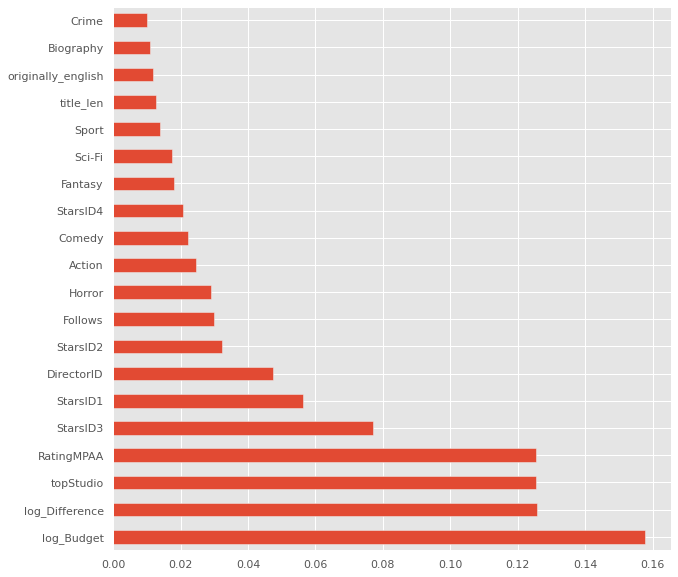

In [115]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

# ***LightGBM***

The last model we will implement is LightGBM. LightGBM is another gradient boosting framework and very comparable to XGBoost, meant to have the advantages in speed and efficiency. It is very lightweight and has lower memory usage and great for large scale data. Let's see how it does on our data.

***Baseline***

In [116]:
lgbm_base_model = LGBMRegressor(random_state=42)
lgbm_base_model.fit(X_train, y_train.values.ravel())

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [117]:
y_pred = lgbm_base_model.predict(X_test)

In [118]:
print('LightGBM Baseline Model Metrics:')
metrics(y_pred, y_test.values)

LightGBM Baseline Model Metrics:
Mean Squared Error:  1.1914
Root Mean Squared Error:  1.0915
Mean Absolute Error:  0.8649
Median Absolute Error:  0.7737
R2 Score:  0.4581
Test Set Accuracy (from Mean Absolute Percentage Error):83.386%


***Grid Search Hyperparameter Tuning***

In [119]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [100, 150],
    'colsample_bytree': [0.8, 1.0, 1.2],
    'max_depth': [-1, 5, 10],
    'reg_alpha': [0.4, 0.5, 0.6],
    'reg_lambda': [0.2, 0.3, 0.4,],
    'subsample': [0.8, 0.9, 1],
    'num_leaves': [30,31,32]
}
# Create a based model
lgbm = LGBMRegressor(random_state=42)
lgbm, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, lgbm, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-lgbm.best_score_))
print(lgbm.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1198 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2088 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3142 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4356 tasks      | elapsed:  4.5min


1.0639560169842583
{'colsample_bytree': 0.8, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.6, 'reg_lambda': 0.3, 'subsample': 0.8}


[Parallel(n_jobs=-1)]: Done 7290 out of 7290 | elapsed:  5.3min finished


In [120]:
lgbm_base_model = LGBMRegressor()
lgbm_base_model.fit(X_train, y_train.values.ravel())
base_accuracy = evaluate(lgbm_base_model, X_test, y_test.values)

lgbm_best_model = lgbm.best_estimator_
best_accuracy = evaluate(lgbm_best_model, X_test, y_test.values)


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Average Error: 0.8649
Accuracy = 83.386%
Average Error: 0.8491
Accuracy = 83.566%
Improvement of 0.22%.


In [121]:
y_pred = lgbm_best_model.predict(X_test)
print('LightGBM Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

LightGBM Model (After Tuning) Metrics:
Mean Squared Error:  1.1406
Root Mean Squared Error:  1.068
Mean Absolute Error:  0.8491
Median Absolute Error:  0.7151
R2 Score:  0.4812
Test Set Accuracy (from Mean Absolute Percentage Error):83.566%


***Feature Importances***

In [123]:
feature_importances = lgbm_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))


Feature ranking:
1. log_Difference (125.000000)
2. log_Budget (124.000000)
3. DirectorID (120.000000)
4. StarsID2 (103.000000)
5. StarsID1 (90.000000)
6. StarsID3 (84.000000)
7. StarsID4 (84.000000)
8. title_len (66.000000)
9. RatingMPAA (37.000000)
10. Horror (20.000000)
11. Fantasy (14.000000)
12. Comedy (14.000000)
13. topStudio (14.000000)
14. Drama (13.000000)
15. Follows (9.000000)
16. Action (8.000000)
17. Sci-Fi (7.000000)
18. Adventure (6.000000)
19. Biography (6.000000)
20. Mystery (5.000000)


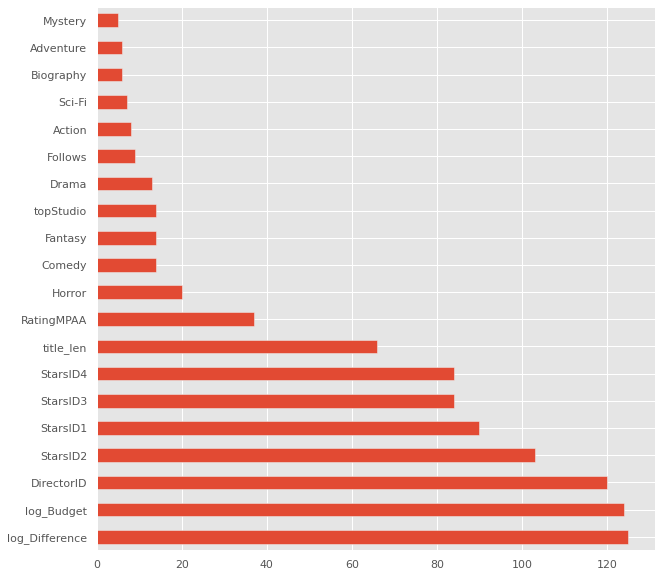

In [124]:

feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])